In [1]:
#John's
import numpy as np
import tensorflow as tf
import os
import time
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import statistics as stat
import ROOT
now = datetime.utcnow().strftime("%y%m%d%H%M%S")

2023-08-07 22:49:00.684997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6fa5c/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-c1d8e/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_103swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

Welcome to JupyROOT 6.28/00


In [2]:
#Mine
import uproot
import pandas as pd
# import numpy as np
import boost_histogram as bh
# import matplotlib.pyplot as plt
import pickle
import gc
import atlasplots as ap
%matplotlib inline

In [297]:
version = 'full_v02'
conv = 'conv'
size = '1mil'
first = 1000000   #first ____ events that were used for training. should = size
stand = True
weightstr = 'finalWeight'

#-------------------------------------------------------------------------------------------------------------

if stand == False:
    standstr = 'nonstand'
elif stand == True:
    standstr = ''

nameofmodel_even = 'fclass_'+version+conv+'_'+size+standstr+'_even'
nameofmodel_odd = 'fclass_'+version+conv+'_'+size+standstr+'_odd'

In [298]:
with open('TRAININGTEST/models/'+nameofmodel_even+'.json') as file:
    f_even = tf.keras.models.model_from_json(file.read())

with open('TRAININGTEST/models/'+nameofmodel_odd+'.json') as file:
    f_odd = tf.keras.models.model_from_json(file.read())

In [299]:
f_even.load_weights('TRAININGTEST/models/'+nameofmodel_even+'.h5')
f_odd.load_weights('TRAININGTEST/models/'+nameofmodel_odd+'.h5')

In [300]:
df_ea = pickle.load(open('TRAININGTEST/data/'+version+'_e'+conv[0]+'2mil_a.pickle', 'rb'))   #even
df_ez = pickle.load(open('TRAININGTEST/data/'+version+'_e'+conv[0]+'2mil_z.pickle', 'rb'))
df_oa = pickle.load(open('TRAININGTEST/data/'+version+'_o'+conv[0]+'2mil_a.pickle', 'rb'))
df_oz = pickle.load(open('TRAININGTEST/data/'+version+'_o'+conv[0]+'2mil_z.pickle', 'rb'))   #odd

In [301]:
# #IF WANT TO PREDICT ON WHOLE 4mil EVENTS FROM a AND z FILES
# df_even = pd.concat([df_ea,df_ez])
# df_odd = pd.concat([df_oa,df_oz])
# del df_ea
# del df_ez
# del df_oa
# del df_oz
# gc.collect()

In [302]:
#IF WANT 'TRAIN' AND 'TEST' PREDICTIONS TO BE JUST EVENTS TRAINED/TESTED ON  (only <size> each, like in NNtraining.py)
df_even = df_ea[:first]
df_odd = df_oa[:first]
del df_ea
del df_ez
del df_oa
del df_oz
gc.collect()

11633

In [303]:
features_stand = ['HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand', 'y_weta2_stand',
                   'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand', 'y_deltae_stand',
                   'y_Eratio_stand', 'y_f1_stand']
features = ['HadLeakage', 'y_Reta', 'y_weta2', 'y_Rphi', 'y_wtots1', 
            'y_weta1', 'y_fracs1', 'y_deltae', 'y_Eratio', 'y_f1']

In [304]:
if stand == True:
    featlist = features_stand
elif stand == False:
    featlist = features

In [305]:
features_even_train = np.array(df_even[featlist])
labels_even_train   = np.array(df_even['y_isTruthMatchedPhoton'])
weights_even_train  = np.array(df_even[weightstr])
features_odd_train = np.array(df_odd[featlist])
labels_odd_train   = np.array(df_odd['y_isTruthMatchedPhoton'])
weights_odd_train  = np.array(df_odd[weightstr])

features_even_test = features_odd_train
labels_even_test = features_odd_train
weights_even_test = features_odd_train
features_odd_test = features_even_train
labels_odd_test = features_even_train
weights_odd_test = features_even_train

In [306]:
y_pred_testeven = f_even.predict(features_even_test).ravel()   #predicting the odd events (even test), using the even model


In [307]:
y_pred_testodd = f_odd.predict(features_odd_test).ravel()    #predicting the even events (odd test), using the odd model

In [308]:
y_pred_traineven = f_even.predict(features_even_train).ravel()   #"predicting" the even, using the even model


In [309]:
y_pred_trainodd = f_odd.predict(features_odd_train).ravel()    #"predicting" the odd, using the odd model

In [310]:
df_all = pd.concat([df_even,df_odd])
y_pred_test = np.concatenate((y_pred_testodd,y_pred_testeven))   #TESTODD means even events, TESTEVEN means odd events
y_pred_train = np.concatenate((y_pred_traineven,y_pred_trainodd))

df_all['y_pred_test'] = y_pred_test
df_all['y_pred_train'] = y_pred_train

In [311]:
TightIDtuple = (0.9125338241031228, 0.7782203268877278)
TightIDtuple = (0.9498026, 0.7725793)

In [312]:
# fprID,tprID,threshID = roc_curve(labels,df_all.y_IsTight.ravel()*1,sample_weight=weights)
# 1-fprID,tprID

Text(0.11, 0.25, 'ATLAS Internal')

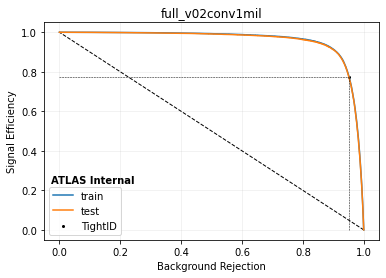

In [321]:
labels = df_all.y_isTruthMatchedPhoton.ravel()
weights = df_all.finalWeight.ravel()

#SWITCH IF DONT HAVE TIGHT ID IN DATAFRAMES
fprID,tprID,threshID = roc_curve(labels,df_all.y_IsTight.ravel()*1,sample_weight=weights)
# fprID=[0,1-TightIDtuple[0]];tprID=[0,TightIDtuple[1]]

fpr_test, tpr_test, thresholds_test = roc_curve(labels,y_pred_test,sample_weight = weights)
fpr_train, tpr_train, thresholds_train = roc_curve(labels,y_pred_train,sample_weight = weights)
plt.plot([1,0],[0,1],'k--',linewidth=1)
plt.plot(1-fpr_train, tpr_train,label='train')
plt.plot(1-fpr_test, tpr_test,label='test')
plt.scatter(1-fprID[1],tprID[1],label='TightID',c='k',s=4)
plt.plot([0,1-fprID[1]],[tprID[1],tprID[1]],'k--',linewidth=.5)
plt.plot([1-fprID[1],1-fprID[1]],[0,tprID[1]],'k--',linewidth=.5)

plt.grid(alpha=0.2)
plt.xlabel('Background Rejection')
plt.ylabel('Signal Efficiency')
plt.title(version+conv+size+standstr);plt.legend()
plt.text(0.11, 0.25, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center')

Text(0.11, 0.41, 'ATLAS Internal')

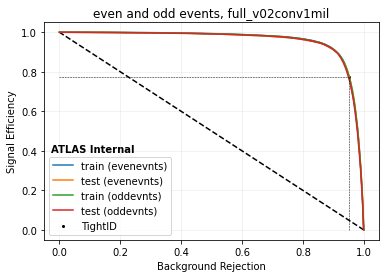

In [322]:
lab1 = df_even.y_isTruthMatchedPhoton.ravel()
lab2 = df_odd.y_isTruthMatchedPhoton.ravel()
weights1 = df_even.finalWeight.ravel()
weights2 = df_odd.finalWeight.ravel()


fprID1,tprID1,threshID1 = roc_curve(lab1,df_even.y_IsTight.ravel()*1,sample_weight=weights1)
fprID2,tprID2,threshID2 = roc_curve(lab2,df_odd.y_IsTight.ravel()*1,sample_weight=weights2)


fpr_test, tpr_test, thresholds_test = roc_curve(lab1,y_pred_testodd,sample_weight = weights1)
fpr_train, tpr_train, thresholds_train = roc_curve(lab1,y_pred_traineven,sample_weight = weights1)
fpr_test2, tpr_test2, thresholds_test2 = roc_curve(lab2,y_pred_testeven,sample_weight = weights2)
fpr_train2, tpr_train2, thresholds_train2 = roc_curve(lab2,y_pred_trainodd,sample_weight = weights2)
plt.plot([1,0],[0,1],'k--')
plt.plot(1-fpr_train, tpr_train,label='train (evenevnts)')
plt.plot(1-fpr_test, tpr_test,label='test (evenevnts)')
plt.plot(1-fpr_train2, tpr_train2,label='train (oddevnts)')
plt.plot(1-fpr_test2, tpr_test2,label='test (oddevnts)')
plt.scatter(1-fprID[1],tprID[1],label='TightID',c='k',s=4)
plt.plot([0,1-fprID[1]],[tprID[1],tprID[1]],'k--',linewidth=.5)
plt.plot([1-fprID[1],1-fprID[1]],[0,tprID[1]],'k--',linewidth=.5)

plt.grid(alpha=.2)
plt.xlabel('Background Rejection')
plt.ylabel('Signal Efficiency')
plt.title('even and odd events, '+version+conv+size+standstr);plt.legend()
plt.text(0.11, 0.41, 'ATLAS Internal', weight='bold',horizontalalignment='center', verticalalignment='center')

In [323]:
df_all.columns

Index(['mcTotWeight', 'goodWeight', 'finalWeight', 'y_pt', 'y_eta',
       'y_isTruthMatchedPhoton', 'y_convType', 'HadLeakage', 'y_Reta',
       'y_weta2', 'y_Rphi', 'y_wtots1', 'y_weta1', 'y_fracs1', 'y_deltae',
       'y_Eratio', 'y_f1', 'HadLeakage_stand', 'y_Reta_stand', 'y_Rphi_stand',
       'y_weta2_stand', 'y_wtots1_stand', 'y_weta1_stand', 'y_fracs1_stand',
       'y_deltae_stand', 'y_Eratio_stand', 'y_f1_stand', 'y_iso_FixedCutLoose',
       'y_iso_FixedCutTight', 'y_iso_FixedCutTightCaloOnly',
       'y_topoetcone20ptCorrection', 'y_topoetcone30ptCorrection',
       'y_topoetcone40ptCorrection', 'y_IsLoose', 'y_IsLoosePrime2',
       'y_IsLoosePrime3', 'y_IsLoosePrime4', 'y_IsTight', 'y_IsEMTight',
       'y_pred_test', 'y_pred_train'],
      dtype='object')

,y_topoetcone20ptCorrection,y_topoetcone30ptCorrection,y_topoetcone40ptCorrection
0,0.414860,0.817604,0.381976
2,3.159697,3.256756,3.058192
4,-0.073427,0.285022,-0.219287
6,0.951138,1.079423,0.752323
8,2.018718,2.205911,1.961592
...,...,...,...
1999991,-0.090409,0.400396,-0.219258
1999993,0.247734,0.595447,0.159395
1999995,1.730941,1.773386,1.784666
1999997,-0.147238,0.352261,-0.322329


In [325]:
#figuring out the thresholds at TIGHTID:

#just going to go with df_all, and test

#fpr
indexsig = np.where(fpr_test < fprID[1])[0][-1]
sig_thresh = thresholds_test[indexsig]

#tpr
indexbkg = np.where(tpr_test < tprID[1])[0][-1]
bkg_thresh = thresholds_test[indexbkg]

In [326]:
sig_thresh,bkg_thresh

(0.830695, 0.8437817)

In [327]:
print('Matching Signal Efficiency Threshold:')
print('NN threshold:',sig_thresh)
print('Signal Efficiency:',1-fpr_test[indexsig])
print('Bkg Rej. of NN:     ', tpr_test[indexsig])
print('Bkg Rej. of TightID:',tprID[1])
print('NN better than TightID?',tpr_test[indexsig]>tprID[1],'by',abs(tpr_test[indexsig]-tprID[1]))
1-fpr_test[indexsig],tpr_test[indexsig],1-fprID[1],tprID[1]

Matching Signal Efficiency Threshold:
NN threshold: 0.830695
Signal Efficiency: 0.9498030358517584
Bkg Rej. of NN:      0.7880905469690258
Bkg Rej. of TightID: 0.7725792965690056
NN better than TightID? True by 0.015511250400020216


(0.9498030358517584,
 0.7880905469690258,
 0.9498025955033345,
 0.7725792965690056)

In [328]:
print('Matching Background Rejection Threshold:')
print('NN threshold:',bkg_thresh)
print('Background Rejection:',tpr_test[indexbkg])
print('Sig Eff. of NN:     ', 1-fpr_test[indexbkg])
print('Sig Eff. of TightID:',1-fprID[1])
print('NN better than TightID?',(1-fpr_test[indexbkg])>(1-fprID[1]),'by',abs((1-fpr_test[indexbkg])-(1-fprID[1])))
1-fpr_test[indexbkg],tpr_test[indexbkg],1-fprID[1],tprID[1]

Matching Background Rejection Threshold:
NN threshold: 0.8437817
Background Rejection: 0.7725792647397557
Sig Eff. of NN:      0.9525313129268342
Sig Eff. of TightID: 0.9498025955033345
NN better than TightID? True by 0.0027287174234997824


(0.9525313129268342,
 0.7725792647397557,
 0.9498025955033345,
 0.7725792965690056)

In [329]:
df_all[['y_topoetcone20ptCorrection','y_topoetcone30ptCorrection','y_topoetcone40ptCorrection']]

,y_topoetcone20ptCorrection,y_topoetcone30ptCorrection,y_topoetcone40ptCorrection
0,0.414860,0.817604,0.381976
2,3.159697,3.256756,3.058192
4,-0.073427,0.285022,-0.219287
6,0.951138,1.079423,0.752323
8,2.018718,2.205911,1.961592
...,...,...,...
1999991,-0.090409,0.400396,-0.219258
1999993,0.247734,0.595447,0.159395
1999995,1.730941,1.773386,1.784666
1999997,-0.147238,0.352261,-0.322329


In [330]:

# from matplotlib import pyplot as PLT
from matplotlib import cm as CM
from matplotlib import mlab as ML
# import numpy as NP

import matplotlib.colors as colors

In [331]:
sig = np.array(df_all.y_isTruthMatchedPhoton)
bkg = np.array(~df_all.y_isTruthMatchedPhoton)

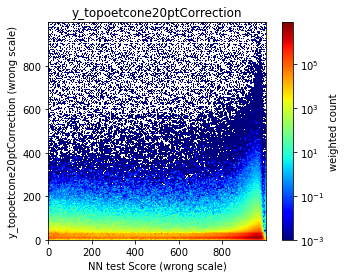

In [341]:
##y_topoetcone20ptCorrection   sig
xsig = df_all.y_pred_test.ravel()[sig]
xbkg = df_all.y_pred_test.ravel()[bkg]


ysig = df_all.y_topoetcone20ptCorrection.ravel()[sig]

heatmap, xedges, yedges = np.histogram2d(xsig, ysig, bins=1000, weights=df_all.finalWeight.ravel()[sig])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('y_topoetcone20ptCorrection SIGNAL')
plt.xlabel('NN test Score (wrong scale)')
plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
plt.show()



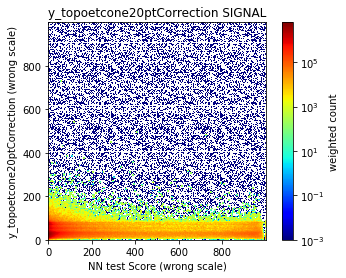

In [347]:
##y_topoetcone20ptCorrection   bkg
xsig = df_all.y_pred_test.ravel()[sig]
xbkg = df_all.y_pred_test.ravel()[bkg]


ybkg = df_all.y_topoetcone20ptCorrection.ravel()[bkg]

heatmap, xedges, yedges = np.histogram2d(xbkg, ybkg, bins=1000, weights=df_all.finalWeight.ravel()[bkg])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('y_topoetcone20ptCorrection BKG')
plt.xlabel('NN test Score (wrong scale)')
plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
plt.show()


In [348]:
#30 and 40 look pretty much the same

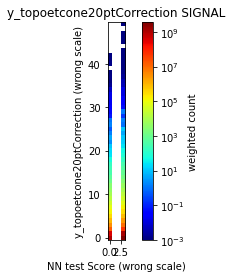

In [355]:
##now with TightID
##y_topoetcone20ptCorrection   sig
xsig = df_all.y_IsTight.ravel()[sig]*1
xbkg = df_all.y_IsTight.ravel()[bkg]*1


ysig = df_all.y_topoetcone20ptCorrection.ravel()[sig]

heatmap, xedges, yedges = np.histogram2d(xsig, ysig, bins=[4,50], weights=df_all.finalWeight.ravel()[sig])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower',cmap=CM.jet, norm=colors.LogNorm(vmin=0.001))#,extent=extent)

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('y_topoetcone20ptCorrection SIGNAL')
plt.xlabel('TightID (wrong scale)')
plt.ylabel('y_topoetcone20ptCorrection (wrong scale)')
plt.show()


In [352]:
np.histogram2d?

In [360]:
df_all.y_IsLoose.ravel()

array([ True,  True,  True, ...,  True, False,  True])

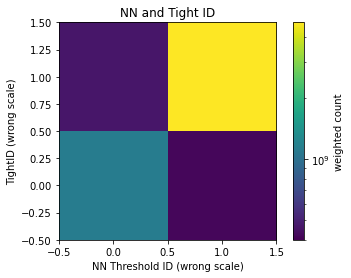

In [377]:
## do four bin 2dhistogram
#separate by sig/bkg?

##  NN vs tight ID

loose = df_all.y_IsLoose.ravel()

x = df_all.y_pred_test.ravel() > sig_thresh
x = x[loose]*1
y = df_all.y_IsTight[loose]

heatmap, xedges, yedges = np.histogram2d(x, y, bins=[2,2], weights=df_all.finalWeight.ravel()[loose])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, origin='lower', norm=colors.LogNorm(vmin=4e8))#,extent=extent)

cb = plt.colorbar()
cb.set_label('weighted count') 

plt.title('NN and Tight ID')
plt.xlabel('NN Threshold ID (wrong scale)')
plt.ylabel('TightID (wrong scale)')
plt.show()


In [ ]:
## put numbers in it^^